# California Wildfire Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd

# Load the dataset with specified dtypes
dtype_dict = {
    'Incident Start Date': 'str',
    'Fire Name (Secondary)': 'str',
    'APN (parcel)': 'str'
}
data = pd.read_csv('CAL_POSTFIRE.csv', dtype=dtype_dict, low_memory=False)

# Display the first few rows of the dataset
data.head()

,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,No Damage,8376.0,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,Affected (1-9%),8402.0,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,No Damage,8430.0,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,No Damage,3838.0,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,No Damage,3830.0,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


## Data Preprocessing

In [17]:
# Check for missing values
data.isnull().mean() *100

OBJECTID                                                         0.000000
* Damage                                                         0.000000
* Street Number                                                  3.381221
* Street Name                                                    4.196692
* Street Type (e.g. road, drive, lane, etc.)                    11.063172
Street Suffix (e.g. apt. 23, blding C)                          52.558100
* City                                                          24.273649
State                                                            0.005355
Zip Code                                                        40.417833
* CAL FIRE Unit                                                  0.000000
County                                                           0.022949
Community                                                       58.127936
Battalion                                                       94.954178
* Incident Name                       

In [18]:
# Calculate the threshold for missing values
threshold = len(data) * 0.65

# Drop columns with more than 65% missing values
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Display the remaining columns
data_cleaned.head()

,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,...,* Fence Attached to Structure,APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,No Damage,8376.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,Affected (1-9%),8402.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,Combustible,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,No Damage,8430.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,No Damage,3838.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,No Damage,3830.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


In [19]:
# Display basic statistics of the dataset
data.describe()

,OBJECTID,* Street Number,Zip Code,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,x,y
count,130722.000000,1.263020e+05,77887.000000,38908.000000,40915.000000,40923.000000,1.238310e+05,99259.000000,130722.000000,130722.000000,1.307220e+05,1.307220e+05
mean,65688.380028,3.049720e+04,63248.626112,0.464326,0.078822,0.108594,7.399900e+05,1755.206117,37.345905,-120.506903,-1.341477e+07,4.493210e+06
std,38126.433935,4.591477e+06,43095.528223,31.016093,0.423407,0.489252,9.507596e+06,607.842358,2.502964,1.819625,2.025598e+05,3.490361e+05
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,32.592548,-123.774580,-1.377852e+07,3.841346e+06
25%,32681.250000,6.900000e+02,0.000000,0.000000,0.000000,0.000000,7.173200e+04,1940.000000,34.195297,-122.128623,-1.359530e+07,4.055056e+06
50%,65361.500000,3.058000e+03,91001.000000,0.000000,0.000000,0.000000,1.650000e+05,1962.000000,38.467951,-121.396271,-1.351377e+07,4.645744e+06
75%,99032.750000,8.500000e+03,93010.000000,0.000000,0.000000,0.000000,3.465480e+05,1983.000000,39.741065,-118.542113,-1.319605e+07,4.828386e+06
max,131869.000000,1.410065e+09,96311.000000,6101.000000,40.000000,20.000000,1.220403e+09,2022.000000,41.991195,-116.418163,-1.295961e+07,5.159661e+06


In [20]:
data.columns

Index(['OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
       'Dis

## Data Visualization

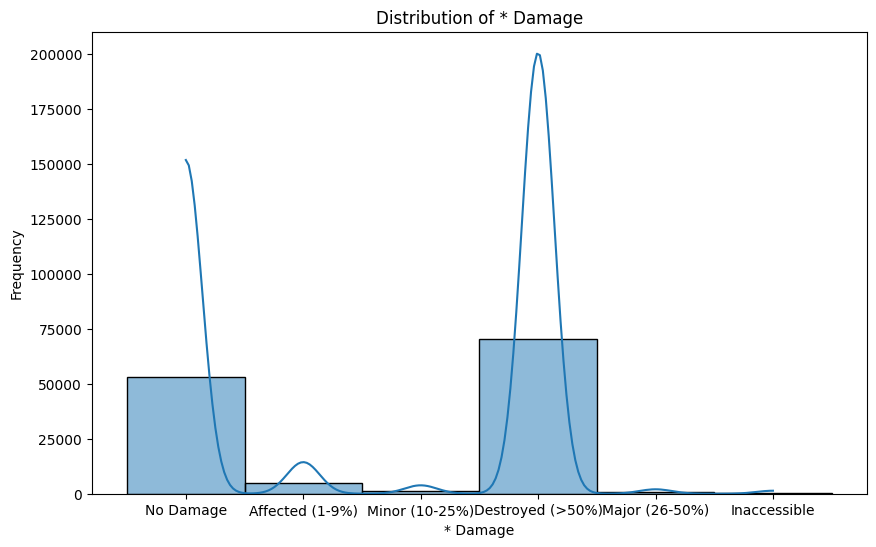

In [21]:
# Data Visualization
# Plotting the distribution of '* Damage'
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['* Damage'], bins=30, kde=True)
plt.title('Distribution of * Damage')
plt.xlabel('* Damage')
plt.ylabel('Frequency')
plt.show()

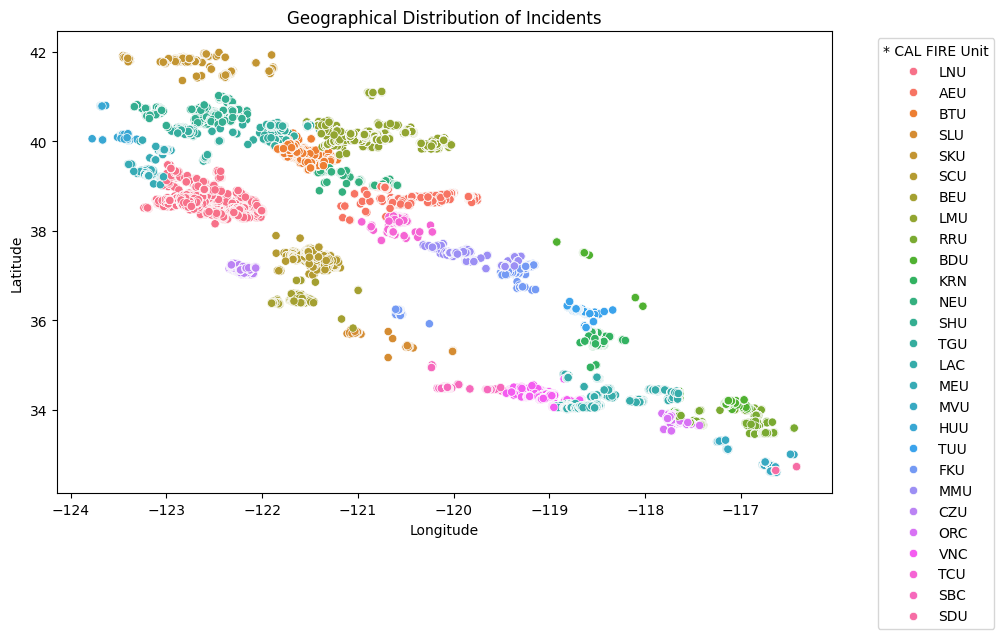

In [23]:
# Scatter plot of 'Latitude' vs 'Longitude' colored by '* CAL FIRE Unit'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='* CAL FIRE Unit', data=data_cleaned)
plt.title('Geographical Distribution of Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='* CAL FIRE Unit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

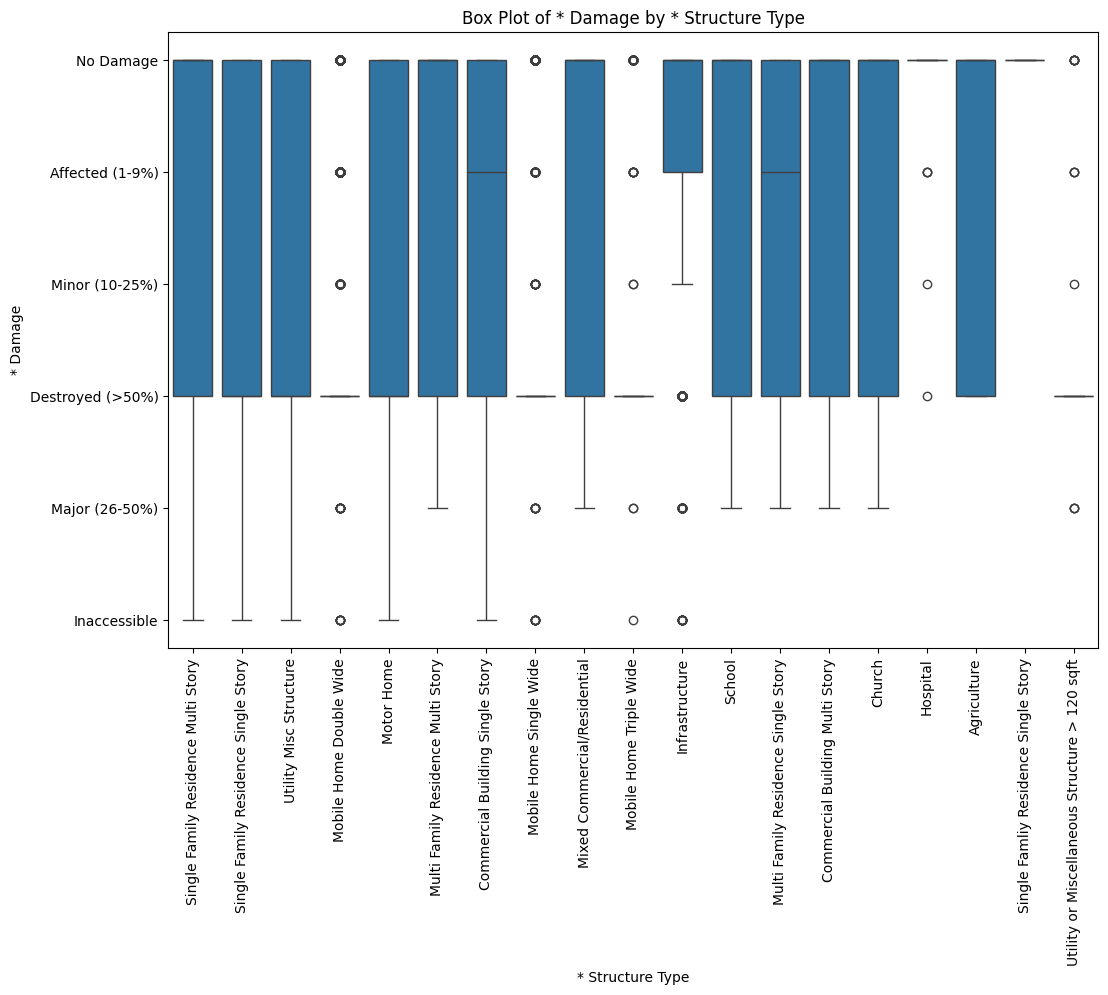

In [27]:
# Box plot of '* Damage' by '* Structure Type'
plt.figure(figsize=(12, 8))
sns.boxplot(x='* Structure Type', y='* Damage', data=data_cleaned)
plt.title('Box Plot of * Damage by * Structure Type')
plt.xlabel('* Structure Type')
plt.ylabel('* Damage')
plt.xticks(rotation=90)
plt.show()

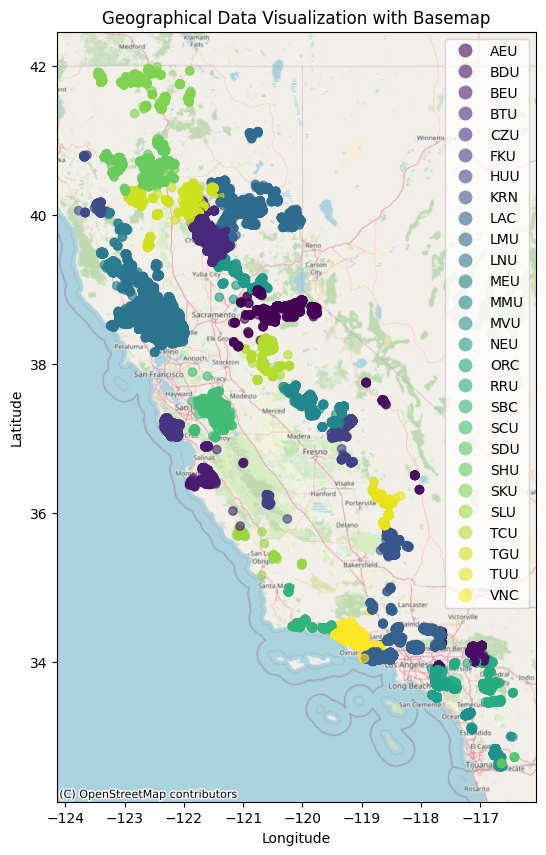

In [36]:
import geopandas as gpd
import contextily as ctx

# Convert the DataFrame to a GeoDataFrame with a specified CRS
gdf = gpd.GeoDataFrame(data_cleaned, geometry=gpd.points_from_xy(data_cleaned.Longitude, data_cleaned.Latitude), crs="EPSG:4326")

# Plot the GeoDataFrame with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='* CAL FIRE Unit', cmap='viridis', legend=True, alpha=0.6, ax=ax)

# Use a different basemap source
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Geographical Data Visualization with Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()